In [5]:
%%bash
cd /storage/group/ibb3/default/darpa/linkage_scaff/
cat 41598_2020_69101_MOESM1_ESM.csv | sed "s/\[\([^]]*\)\]/N/g" > 41598_2020_69101_MOESM1_ESM_replaceN.csv

In [21]:
import pandas as pd
import numpy as np
import re

In [2]:
probesets = pd.read_csv("/storage/group/ibb3/default/darpa/linkage_scaff/41598_2020_69101_MOESM1_ESM_replaceN.csv", comment = "#")

In [86]:
probesets[["Probe Set ID", "Flank"]].set_index("Probe Set ID").to_csv("/storage/group/ibb3/default/darpa/linkage_scaff/tmp_out.csv", header = None, sep = " ")

In [87]:
%%bash
cd /storage/group/ibb3/default/darpa/linkage_scaff/
cat tmp_out.csv | sed "s/AX/>AX/g" | sed "s/\s/\n/g" > probes.fasta

In [5]:
%%bash
source ~/.bashrc
conda activate funannotate
cd /storage/group/ibb3/default/darpa/linkage_scaff/
funannotate sort --input /storage/group/ibb3/default/genome_annotation/Apalm_dovetail_assemblies/Apalm_assembly_v2.0_180910.softmasked.fa \
  -o sorted.fa

441 contigs records loaded
Sorting and renaming contig headers
441 contigs saved to file


In [6]:
%%bash
source ~/.bashrc
conda activate ipyrad
cd /storage/group/ibb3/default/darpa/linkage_scaff/
bwa index sorted.fa

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


[bwa_index] Pack FASTA... 1.62 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=608504144, availableWord=54816184
[BWTIncConstructFromPacked] 10 iterations done. 87465408 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 164423936 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 232820832 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 293608160 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 347632080 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 395644672 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 438314352 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 476235216 characters processed.
[BWTIncConstructFromPacked] 90 iterations done. 509935408 characters processed.
[BWTIncConstructFromPacked] 100 iterations done. 539884176 characters processed.
[BWTIncConstructFromPacked] 110 iterations done. 566

In [7]:
%%bash
source ~/.bashrc
conda activate ipyrad
cd /storage/group/ibb3/default/darpa/linkage_scaff/
bwa mem \
    sorted.fa \
    /storage/group/ibb3/default/darpa/linkage_scaff/probes.fasta \
    > probes_aln_acer.sam

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 53589 sequences (3803707 bp)...
[M::mem_process_seqs] Processed 53589 reads in 3.437 CPU sec, 3.447 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem sorted.fa /storage/group/ibb3/default/convert_snpchip_coords/probes.fasta
[main] Real time: 4.073 sec; CPU: 3.635 sec


In [10]:
%%bash
source ~/.bashrc
conda activate ipyrad
cd /storage/group/ibb3/default/darpa/linkage_scaff/
sambamba view -t 4 --sam-input \
    -F "mapping_quality >= 3 and not (unmapped or secondary_alignment or supplementary or duplicate)" \
    ./probes_aln_acer.sam > ./unique_mappings_apal_probes.sam

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



sambamba 0.7.1
 by Artem Tarasov and Pjotr Prins (C) 2012-2019
    LDC 1.20.0 / DMD v2.090.1 / LLVM7.0.0 / bootstrap LDC - the LLVM D compiler (0.17.6)



In [11]:
%%bash
cd /storage/group/ibb3/default/darpa/linkage_scaff/
cut -f1,3,4,5,6,10,12 /storage/group/ibb3/default/darpa/linkage_scaff/unique_mappings_acer_probes.sam \
    > /storage/group/ibb3/default/darpa/linkage_scaff/unique_mappings_acer_probes.tab

In [30]:
probes = pd.read_csv("/storage/group/ibb3/default/darpa/linkage_scaff/unique_mappings_acer_probes.tab", comment = "@", sep = "\t", names = ["probe", "contig", "start", "mapq", "cigar", "seq", "mismatch"])

In [31]:
probes = probes[probes["mapq"] > 20].reset_index(drop=True)
probes["npos"] = np.nan
for i in range(len(probes)):
    probes["npos"][i] = probes["seq"][i].find("N")
probes["new_snp_pos"] = np.nan
probes.loc[~probes["cigar"].str.contains("I|D"), "new_snp_pos"] = probes["npos"]

/tmp/ipykernel_2659982/435527431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["npos"][i] = probes["seq"][i].find("N")


In [32]:
for i in range(len(probes)):
    cigar = re.findall('(\d+)?([A-Za-z])', probes["cigar"][i])
    length = len(cigar)
    if (length < 4) and (length > 2):
        if ( cigar[0][1] == "S" ) and ( cigar[1][1] == "M" ) and ( cigar[2][1] == "S" ):
            print
        elif ( cigar[0][1] == "M" ) and ( cigar[2][1] == "M" ):
            if int(cigar[0][0]) > probes["seq"][i].find("N"):
                probes["new_snp_pos"][i] = probes["seq"][i].find("N")
            elif int(cigar[0][0]) < probes["seq"][i].find("N"):
                if cigar[1][1] == "I":
                    if (int(cigar[0][0]) + int(cigar[1][0])) > probes["npos"][i]:
                        pass
                    else:
                        probes["new_snp_pos"][i] = probes["seq"][i].find("N") + int(cigar[1][0])
                elif cigar[1][1] == "D":
                    if (int(cigar[0][0]) + int(cigar[1][0])) > probes["npos"][i]:
                        pass
                    else:
                        probes["new_snp_pos"][i] = probes["seq"][i].find("N") - int(cigar[1][0])
    if (length > 3):
        if ( cigar[0][1] == "S" ) and ( cigar[1][1] == "M" ):
            if (int(cigar[0][0]) + int(cigar[1][0])) >= probes["seq"][i].find("N"):
                probes["new_snp_pos"][i] = probes["seq"][i].find("N")
    if ( cigar[0][1] == "M" ) and ( int(cigar[0][0]) >= probes["seq"][i].find("N") ):
        probes["new_snp_pos"][i] = probes["seq"][i].find("N")

/tmp/ipykernel_2659982/1691801142.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["new_snp_pos"][i] = probes["seq"][i].find("N")
/tmp/ipykernel_2659982/1691801142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["new_snp_pos"][i] = probes["seq"][i].find("N") - int(cigar[1][0])
/tmp/ipykernel_2659982/1691801142.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["new_snp_pos"][i] = probes["seq"][i].find("N"

In [33]:
probes["new_snp_pos"] = probes["start"] + probes["new_snp_pos"]

In [34]:
probes = probes[probes["new_snp_pos"].notna()].reset_index(drop=True)
probes["new_snp_pos"] = probes["new_snp_pos"].astype(int)

In [35]:
recommended = pd.read_csv("/storage/group/ibb3/default/acropora_linkage_maps/Apalm_linkage_Map/plate1-2/recommended.txt", header = None)

In [36]:
probes = probes[probes["probe"].isin(recommended[0].tolist())].reset_index(drop=True)

In [37]:
!rm /storage/group/ibb3/default/darpa/linkage_scaff/probes_in_acer.txt

rm: cannot remove '/storage/group/ibb3/default/darpa/linkage_scaff/probes_in_acer.txt': No such file or directory


In [38]:
file = open('/storage/group/ibb3/default/darpa/linkage_scaff/probes_in_acer.txt','w')
for item in probes["probe"].tolist():
    file.write(item+"\n")
file.close()

In [39]:
%%bash
source ~/.bashrc
conda activate ipyrad
cd /storage/group/ibb3/default/darpa/linkage_scaff/
vcftools --vcf /storage/group/ibb3/default/acropora_linkage_maps/Apalm_linkage_Map/plate1-2/Lep-MAP3/Apalm_link_rename.vcf \
    --snps probes_in_acer.txt \
    --recode --out ./conserved_probes_kate

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf /storage/group/ibb3/default/acropora_linkage_maps/Apalm_linkage_Map/plate1-2/Lep-MAP3/Apalm_link_rename.vcf
	--out ./conserved_probes_kate
	--recode
	--snps probes_in_acer.txt

After filtering, kept 107 out of 107 Individuals
Outputting VCF file...
After filtering, kept 22437 out of a possible 26075 Sites
Run Time = 5.00 seconds


In [40]:
reformat = probes[["contig", "start", "probe"]]

In [41]:
reformat.columns = ["contig", "start", "ID"]

In [42]:
%%bash
cd /storage/group/ibb3/default/darpa/linkage_scaff/
grep -v "^##" ./conserved_probes_kate.recode.vcf | cut -f1-3 \
    > ./original_coords_kate.tab

In [43]:
tmp = pd.read_csv("/storage/group/ibb3/default/darpa/linkage_scaff/original_coords_kate.tab", sep = "\t")

In [44]:
tmp = tmp.merge(reformat, how = "left", on = "ID")

In [45]:
reformatted_positions = tmp[["contig", "start", "ID"]]
reformatted_positions.columns = ["#CHROM", "POS", "ID"]

In [46]:
reformatted_positions.set_index("#CHROM").to_csv("/storage/group/ibb3/default/darpa/linkage_scaff/remapped_coords_kate.tab", sep = "\t")

In [47]:
%%bash
cd /storage/group/ibb3/default/darpa/linkage_scaff/
grep -e "^##fileformat" -e "^##FORMAT" -e "^##INFO" conserved_probes_kate.recode.vcf \
    > acer_snpchip_remapped_kate.vcf

In [48]:
%%bash
cd /storage/group/ibb3/default/darpa/linkage_scaff/
paste /storage/group/ibb3/default/darpa/linkage_scaff/remapped_coords_kate.tab \
    <( grep -v "^##" conserved_probes_kate.recode.vcf | cut -f4- ) \
    >> acer_snpchip_remapped_kate.vcf

In [49]:
%%bash
cd /storage/group/ibb3/default/darpa/linkage_scaff/
grep "^#" acer_snpchip_remapped_kate.vcf > acer_snpchip_remapped_kate_sorted.vcf
grep -v "^#" acer_snpchip_remapped_kate.vcf | sort -k1,1V -k2,2g >> acer_snpchip_remapped_kate_sorted.vcf

In [50]:
%%bash
source ~/.bashrc
conda activate ipyrad
cd /storage/group/ibb3/default/darpa/linkage_scaff/

for i in acer_snpchip_remapped_kate_sorted.vcf; do
    vcftools --vcf ${i} \
        --max-missing 0.75 --min-alleles 2 --max-alleles 2 --maf 0.05 \
        --recode --out ${i}
done

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf acer_snpchip_remapped_kate_sorted.vcf
	--maf 0.05
	--max-alleles 2
	--min-alleles 2
	--max-missing 0.75
	--out acer_snpchip_remapped_kate_sorted.vcf
	--recode

After filtering, kept 107 out of 107 Individuals
Outputting VCF file...
After filtering, kept 4439 out of a possible 22437 Sites
Run Time = 1.00 seconds


In [51]:
import pandas as pd
import numpy as np
import re

In [52]:
katelinkage = pd.read_csv("/storage/group/ibb3/default/darpa/linkage_scaff/linkage_maps_1.csv", 
            sep = "\s", names = ["LG", "probe", "genetic position"])

/tmp/ipykernel_2659982/3485389430.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  katelinkage = pd.read_csv("/storage/group/ibb3/default/darpa/linkage_scaff/linkage_maps_1.csv",


In [53]:
probes = pd.read_csv("/storage/group/ibb3/default/darpa/linkage_scaff/unique_mappings_acer_probes.tab", comment = "@", sep = "\t", names = ["probe", "contig", "start", "mapq", "cigar", "seq", "mismatch"])

In [54]:
probes = probes[probes["mapq"] > 20].reset_index(drop=True)
probes["npos"] = np.nan
for i in range(len(probes)):
    probes["npos"][i] = probes["seq"][i].find("N")
probes["new_snp_pos"] = np.nan
probes.loc[~probes["cigar"].str.contains("I|D"), "new_snp_pos"] = probes["npos"]

/tmp/ipykernel_2659982/435527431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["npos"][i] = probes["seq"][i].find("N")


In [55]:
for i in range(len(probes)):
    cigar = re.findall('(\d+)?([A-Za-z])', probes["cigar"][i])
    length = len(cigar)
    if (length < 4) and (length > 2):
        if ( cigar[0][1] == "S" ) and ( cigar[1][1] == "M" ) and ( cigar[2][1] == "S" ):
            print
        elif ( cigar[0][1] == "M" ) and ( cigar[2][1] == "M" ):
            if int(cigar[0][0]) > probes["seq"][i].find("N"):
                probes["new_snp_pos"][i] = probes["seq"][i].find("N")
            elif int(cigar[0][0]) < probes["seq"][i].find("N"):
                if cigar[1][1] == "I":
                    if (int(cigar[0][0]) + int(cigar[1][0])) > probes["npos"][i]:
                        pass
                    else:
                        probes["new_snp_pos"][i] = probes["seq"][i].find("N") + int(cigar[1][0])
                elif cigar[1][1] == "D":
                    if (int(cigar[0][0]) + int(cigar[1][0])) > probes["npos"][i]:
                        pass
                    else:
                        probes["new_snp_pos"][i] = probes["seq"][i].find("N") - int(cigar[1][0])
    if (length > 3):
        if ( cigar[0][1] == "S" ) and ( cigar[1][1] == "M" ):
            if (int(cigar[0][0]) + int(cigar[1][0])) >= probes["seq"][i].find("N"):
                probes["new_snp_pos"][i] = probes["seq"][i].find("N")
    if ( cigar[0][1] == "M" ) and ( int(cigar[0][0]) >= probes["seq"][i].find("N") ):
        probes["new_snp_pos"][i] = probes["seq"][i].find("N")

/tmp/ipykernel_2659982/1691801142.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["new_snp_pos"][i] = probes["seq"][i].find("N")
/tmp/ipykernel_2659982/1691801142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["new_snp_pos"][i] = probes["seq"][i].find("N") - int(cigar[1][0])
/tmp/ipykernel_2659982/1691801142.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probes["new_snp_pos"][i] = probes["seq"][i].find("N"

In [56]:
probes["new_snp_pos"] = probes["start"] + probes["new_snp_pos"]

In [57]:
probes = probes[probes["new_snp_pos"].notna()].reset_index(drop=True)
probes["new_snp_pos"] = probes["new_snp_pos"].astype(int)

In [58]:
recommended = pd.read_csv("/storage/group/ibb3/default/acropora_linkage_maps/Apalm_linkage_Map/plate1-2/recommended.txt", header = None)

In [59]:
probes = probes[probes["probe"].isin(recommended[0].tolist())].reset_index(drop=True)

In [60]:
probes = probes[["contig", "new_snp_pos", "probe"]]
probes.columns = ["Scaffold ID", "scaffold position", "probe"]

katelinkage = katelinkage.merge(probes, how = "left", on = "probe")
katelinkage.columns = ["LinkageGroup", "probe", "GeneticPosition", "ScaffoldID", "ScaffoldPosition"]
katelinkage = katelinkage[["ScaffoldID", "ScaffoldPosition", "LinkageGroup", "GeneticPosition"]]
katelinkage = katelinkage[katelinkage["ScaffoldPosition"].notna()].reset_index(drop=True)
katelinkage["ScaffoldPosition"] = katelinkage["ScaffoldPosition"].astype(int)
(katelinkage.set_index("ScaffoldID")
 .to_csv("/storage/group/ibb3/default/darpa/linkage_scaff/linkage_map_1.csv"))

In [63]:
%%bash
source ~/.bashrc
conda activate allmaps
cd /storage/group/ibb3/default/darpa/linkage_scaff/
python -m jcvi.assembly.allmaps merge linkage_map_1.csv -o linkage_merged.bed

[13:45:52] INFO     Set text.usetex=False. Font styles may be inconsistent.                                     base.py:402
           DEBUG    A total of 1292 markers written to `linkage_merged.bed`.                                allmaps.py:1281
           DEBUG    Weights file `weights.txt` found. Will not overwrite.                                   allmaps.py:1328


In [64]:
%%bash
source ~/.bashrc
conda activate allmaps
cd /storage/group/ibb3/default/darpa/linkage_scaff/
python -m jcvi.assembly.allmaps path --renumber --noplot --notex --renumber linkage_merged.bed \
    sorted.fa

[13:46:22] INFO     Set text.usetex=False. Font styles may be inconsistent.                                     base.py:402
           INFO     Set text.usetex=False. Font styles may be inconsistent.                                     base.py:402
           DEBUG    Load file `linkage_merged.bed`                                                               base.py:33
           DEBUG    Map contains 1292 markers in 14 linkage groups.                                          allmaps.py:546
[01:46:22 PM] DEBUG    Retained 1,282 of 1,292 (99.2%) clean markers.                                        allmaps.py:593
              DEBUG    Load file `weights.txt`                                                                   base.py:33
              DEBUG    Imported 1 records from `weights.txt`.                                                   base.py:102
              DEBUG    Map weights: odict_items([('linkage_map_1', 1)])                                      allmaps.py:659
        

Current iteration 20: max_score=(78.0,)
Current iteration 40: max_score=(78.0,)
Current iteration 60: max_score=(78.0,)
Current iteration 80: max_score=(78.0,)
Current iteration 100: max_score=(78.0,)
Current iteration 120: max_score=(78.0,)
Current iteration 140: max_score=(78.0,)
Current iteration 160: max_score=(78.0,)
Current iteration 180: max_score=(78.0,)
Current iteration 200: max_score=(78.0,)
Current iteration 220: max_score=(78.0,)
Current iteration 240: max_score=(78.0,)
Current iteration 260: max_score=(78.0,)
Current iteration 280: max_score=(78.0,)
Current iteration 300: max_score=(78.0,)
Current iteration 320: max_score=(78.0,)
Current iteration 340: max_score=(78.0,)
Current iteration 360: max_score=(78.0,)
Current iteration 380: max_score=(78.0,)
Current iteration 400: max_score=(78.0,)
Current iteration 420: max_score=(78.0,)
Current iteration 440: max_score=(78.0,)
Current iteration 460: max_score=(78.0,)
Current iteration 480: max_score=(78.0,)
Current iteration 50

[01:46:31 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (78.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(78.0,)
Current iteration 40: max_score=(78.0,)
Current iteration 60: max_score=(78.0,)
Current iteration 80: max_score=(78.0,)
Current iteration 100: max_score=(78.0,)
Current iteration 120: max_score=(78.0,)
Current iteration 140: max_score=(78.0,)
Current iteration 160: max_score=(78.0,)
Current iteration 180: max_score=(78.0,)
Current iteration 200: max_score=(78.0,)
Current iteration 220: max_score=(78.0,)
Current iteration 240: max_score=(78.0,)
Current iteration 260: max_score=(78.0,)
Current iteration 280: max_score=(78.0,)
Current iteration 300: max_score=(78.0,)
Current iteration 320: max_score=(78.0,)
Current iteration 340: max_score=(78.0,)
Current iteration 360: max_score=(78.0,)
Current iteration 380: max_score=(78.0,)
Current iteration 400: max_score=(78.0,)
Current iteration 420: max_score=(78.0,)
Current iteration 440: max_score=(78.0,)
Current iteration 460: max_score=(78.0,)
Current iteration 480: max_score=(78.0,)
Current iteration 50

[01:46:33 PM] DEBUG    No fitness improvement: (78.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 0 minor scaffolds                                                             allmaps.py:432
>chr1 (linkage_map_1-1) FINAL
scaffold_1+ scaffold_35- scaffold_7-
              DEBUG    Working on linkage_map_1-2 ...                                                       allmaps.py:1581
              DEBUG    Graph size: |V|=6, |E|=20                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=56, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:46:38 PM] INFO     Objective: 7004550                                                                        tsp.py:113
              INFO     Route distance: 1000100                                                                   tsp.py:121
              DEBUG    Start EC round 0                          

Current iteration 20: max_score=(39.0,)
Current iteration 40: max_score=(39.0,)
Current iteration 60: max_score=(39.0,)
Current iteration 80: max_score=(39.0,)
Current iteration 100: max_score=(39.0,)
Current iteration 120: max_score=(39.0,)
Current iteration 140: max_score=(39.0,)
Current iteration 160: max_score=(39.0,)
Current iteration 180: max_score=(39.0,)
Current iteration 200: max_score=(39.0,)
Current iteration 220: max_score=(39.0,)
Current iteration 240: max_score=(39.0,)
Current iteration 260: max_score=(39.0,)
Current iteration 280: max_score=(39.0,)
Current iteration 300: max_score=(39.0,)
Current iteration 320: max_score=(39.0,)
Current iteration 340: max_score=(39.0,)
Current iteration 360: max_score=(39.0,)
Current iteration 380: max_score=(39.0,)
Current iteration 400: max_score=(39.0,)
Current iteration 420: max_score=(39.0,)
Current iteration 440: max_score=(39.0,)
Current iteration 460: max_score=(39.0,)
Current iteration 480: max_score=(39.0,)
Current iteration 50

[01:46:39 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (39.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(39.0,)
Current iteration 40: max_score=(39.0,)
Current iteration 60: max_score=(39.0,)
Current iteration 80: max_score=(39.0,)
Current iteration 100: max_score=(39.0,)
Current iteration 120: max_score=(39.0,)
Current iteration 140: max_score=(39.0,)
Current iteration 160: max_score=(39.0,)
Current iteration 180: max_score=(39.0,)
Current iteration 200: max_score=(39.0,)
Current iteration 220: max_score=(39.0,)
Current iteration 240: max_score=(39.0,)
Current iteration 260: max_score=(39.0,)
Current iteration 280: max_score=(39.0,)
Current iteration 300: max_score=(39.0,)
Current iteration 320: max_score=(39.0,)
Current iteration 340: max_score=(39.0,)
Current iteration 360: max_score=(39.0,)
Current iteration 380: max_score=(39.0,)
Current iteration 400: max_score=(39.0,)
Current iteration 420: max_score=(39.0,)
Current iteration 440: max_score=(39.0,)
Current iteration 460: max_score=(39.0,)
Current iteration 480: max_score=(39.0,)
Current iteration 50

[01:46:41 PM] DEBUG    No fitness improvement: (39.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 1 minor scaffolds                                                             allmaps.py:432
>chr2 (linkage_map_1-2) FINAL
scaffold_12- scaffold_153? scaffold_18-
              DEBUG    Working on linkage_map_1-3 ...                                                       allmaps.py:1581
              DEBUG    Graph size: |V|=13, |E|=132                                                           allmaps.py:285
              DEBUG    TSP rescale: max_x=148, min_x=-10000, inf=20000, factor=100                                tsp.py:48
[01:46:46 PM] INFO     Objective: 14004700                                                                       tsp.py:113
              INFO     Route distance: 1000100                                                                   tsp.py:121
              DEBUG    Start EC round 0                       

Current iteration 20: max_score=(88.0,)
Current iteration 40: max_score=(88.0,)
Current iteration 60: max_score=(88.0,)
Current iteration 80: max_score=(88.0,)
Current iteration 100: max_score=(88.0,)
Current iteration 120: max_score=(88.0,)
Current iteration 140: max_score=(88.0,)
Current iteration 160: max_score=(88.0,)
Current iteration 180: max_score=(88.0,)
Current iteration 200: max_score=(88.0,)
Current iteration 220: max_score=(88.0,)
Current iteration 240: max_score=(88.0,)
Current iteration 260: max_score=(88.0,)
Current iteration 280: max_score=(88.0,)
Current iteration 300: max_score=(88.0,)
Current iteration 320: max_score=(88.0,)
Current iteration 340: max_score=(88.0,)
Current iteration 360: max_score=(88.0,)
Current iteration 380: max_score=(88.0,)
Current iteration 400: max_score=(88.0,)
Current iteration 420: max_score=(88.0,)
Current iteration 440: max_score=(88.0,)
Current iteration 460: max_score=(88.0,)
Current iteration 480: max_score=(88.0,)
Current iteration 50

[01:46:48 PM] DEBUG    Fixed orientations for 1 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (88.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(88.0,)
Current iteration 40: max_score=(88.0,)
Current iteration 60: max_score=(88.0,)
Current iteration 80: max_score=(88.0,)
Current iteration 100: max_score=(88.0,)
Current iteration 120: max_score=(88.0,)
Current iteration 140: max_score=(88.0,)
Current iteration 160: max_score=(88.0,)
Current iteration 180: max_score=(88.0,)
Current iteration 200: max_score=(88.0,)
Current iteration 220: max_score=(88.0,)
Current iteration 240: max_score=(88.0,)
Current iteration 260: max_score=(88.0,)
Current iteration 280: max_score=(88.0,)
Current iteration 300: max_score=(88.0,)
Current iteration 320: max_score=(88.0,)
Current iteration 340: max_score=(88.0,)
Current iteration 360: max_score=(88.0,)
Current iteration 380: max_score=(88.0,)
Current iteration 400: max_score=(88.0,)
Current iteration 420: max_score=(88.0,)
Current iteration 440: max_score=(88.0,)
Current iteration 460: max_score=(88.0,)
Current iteration 480: max_score=(88.0,)
Current iteration 50

[01:46:50 PM] DEBUG    No fitness improvement: (88.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 3 minor scaffolds                                                             allmaps.py:432
>chr3 (linkage_map_1-3) FINAL
scaffold_51- scaffold_98? scaffold_100? scaffold_2+ scaffold_52+ scaffold_236? scaffold_32- scaffold_9-
              DEBUG    Working on linkage_map_1-4 ...                                                       allmaps.py:1581
              DEBUG    Graph size: |V|=8, |E|=42                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=85, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:46:55 PM] INFO     Objective: 9006000                                                                        tsp.py:113
              INFO     Route distance: 1000100                                                                   tsp.py:12

Current iteration 20: max_score=(66.0,)
Current iteration 40: max_score=(66.0,)
Current iteration 60: max_score=(66.0,)
Current iteration 80: max_score=(66.0,)
Current iteration 100: max_score=(66.0,)
Current iteration 120: max_score=(66.0,)
Current iteration 140: max_score=(66.0,)
Current iteration 160: max_score=(66.0,)
Current iteration 180: max_score=(66.0,)
Current iteration 200: max_score=(66.0,)
Current iteration 220: max_score=(66.0,)
Current iteration 240: max_score=(66.0,)
Current iteration 260: max_score=(66.0,)
Current iteration 280: max_score=(66.0,)
Current iteration 300: max_score=(66.0,)
Current iteration 320: max_score=(66.0,)
Current iteration 340: max_score=(66.0,)
Current iteration 360: max_score=(66.0,)
Current iteration 380: max_score=(66.0,)
Current iteration 400: max_score=(66.0,)
Current iteration 420: max_score=(66.0,)
Current iteration 440: max_score=(66.0,)
Current iteration 460: max_score=(66.0,)
Current iteration 480: max_score=(66.0,)
Current iteration 50

[01:46:56 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (66.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(66.0,)
Current iteration 40: max_score=(66.0,)
Current iteration 60: max_score=(66.0,)
Current iteration 80: max_score=(66.0,)
Current iteration 100: max_score=(66.0,)
Current iteration 120: max_score=(66.0,)
Current iteration 140: max_score=(66.0,)
Current iteration 160: max_score=(66.0,)
Current iteration 180: max_score=(66.0,)
Current iteration 200: max_score=(66.0,)
Current iteration 220: max_score=(66.0,)
Current iteration 240: max_score=(66.0,)
Current iteration 260: max_score=(66.0,)
Current iteration 280: max_score=(66.0,)
Current iteration 300: max_score=(66.0,)
Current iteration 320: max_score=(66.0,)
Current iteration 340: max_score=(66.0,)
Current iteration 360: max_score=(66.0,)
Current iteration 380: max_score=(66.0,)
Current iteration 400: max_score=(66.0,)
Current iteration 420: max_score=(66.0,)
Current iteration 440: max_score=(66.0,)
Current iteration 460: max_score=(66.0,)
Current iteration 480: max_score=(66.0,)
Current iteration 50

[01:46:58 PM] DEBUG    No fitness improvement: (66.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 2 minor scaffolds                                                             allmaps.py:432
>chr4 (linkage_map_1-4) FINAL
scaffold_3+ scaffold_57- scaffold_198? scaffold_20-
              DEBUG    Working on linkage_map_1-5 ...                                                       allmaps.py:1581
              DEBUG    Graph size: |V|=6, |E|=20                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=83, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:47:03 PM] INFO     Objective: 7001550                                                                        tsp.py:113
              INFO     Route distance: 1000150                                                                   tsp.py:121
              DEBUG    Start EC round 0           

Current iteration 20: max_score=(48.0,)
Current iteration 40: max_score=(48.0,)
Current iteration 60: max_score=(48.0,)
Current iteration 80: max_score=(48.0,)
Current iteration 100: max_score=(48.0,)
Current iteration 120: max_score=(48.0,)
Current iteration 140: max_score=(48.0,)
Current iteration 160: max_score=(48.0,)
Current iteration 180: max_score=(48.0,)
Current iteration 200: max_score=(48.0,)
Current iteration 220: max_score=(48.0,)
Current iteration 240: max_score=(48.0,)
Current iteration 260: max_score=(48.0,)
Current iteration 280: max_score=(48.0,)
Current iteration 300: max_score=(48.0,)
Current iteration 320: max_score=(48.0,)
Current iteration 340: max_score=(48.0,)
Current iteration 360: max_score=(48.0,)
Current iteration 380: max_score=(48.0,)
Current iteration 400: max_score=(48.0,)
Current iteration 420: max_score=(48.0,)
Current iteration 440: max_score=(48.0,)
Current iteration 460: max_score=(48.0,)
Current iteration 480: max_score=(48.0,)
Current iteration 50

[01:47:04 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (48.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(48.0,)
Current iteration 40: max_score=(48.0,)
Current iteration 60: max_score=(48.0,)
Current iteration 80: max_score=(48.0,)
Current iteration 100: max_score=(48.0,)
Current iteration 120: max_score=(48.0,)
Current iteration 140: max_score=(48.0,)
Current iteration 160: max_score=(48.0,)
Current iteration 180: max_score=(48.0,)
Current iteration 200: max_score=(48.0,)
Current iteration 220: max_score=(48.0,)
Current iteration 240: max_score=(48.0,)
Current iteration 260: max_score=(48.0,)
Current iteration 280: max_score=(48.0,)
Current iteration 300: max_score=(48.0,)
Current iteration 320: max_score=(48.0,)
Current iteration 340: max_score=(48.0,)
Current iteration 360: max_score=(48.0,)
Current iteration 380: max_score=(48.0,)
Current iteration 400: max_score=(48.0,)
Current iteration 420: max_score=(48.0,)
Current iteration 440: max_score=(48.0,)
Current iteration 460: max_score=(48.0,)
Current iteration 480: max_score=(48.0,)
Current iteration 50

[01:47:06 PM] DEBUG    No fitness improvement: (48.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 0 minor scaffolds                                                             allmaps.py:432
>chr5 (linkage_map_1-5) FINAL
scaffold_73? scaffold_45- scaffold_4- scaffold_24+
              DEBUG    Working on linkage_map_1-6 ...                                                       allmaps.py:1581
              DEBUG    Graph size: |V|=9, |E|=56                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=91, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:47:11 PM] INFO     Objective: 10001950                                                                       tsp.py:113
              INFO     Route distance: 1000300                                                                   tsp.py:121
              DEBUG    Start EC round 0            

Current iteration 20: max_score=(57.0,)
Current iteration 40: max_score=(57.0,)
Current iteration 60: max_score=(57.0,)
Current iteration 80: max_score=(57.0,)
Current iteration 100: max_score=(57.0,)
Current iteration 120: max_score=(57.0,)
Current iteration 140: max_score=(57.0,)
Current iteration 160: max_score=(57.0,)
Current iteration 180: max_score=(57.0,)
Current iteration 200: max_score=(57.0,)
Current iteration 220: max_score=(57.0,)
Current iteration 240: max_score=(57.0,)
Current iteration 260: max_score=(57.0,)
Current iteration 280: max_score=(57.0,)
Current iteration 300: max_score=(57.0,)
Current iteration 320: max_score=(57.0,)
Current iteration 340: max_score=(57.0,)
Current iteration 360: max_score=(57.0,)
Current iteration 380: max_score=(57.0,)
Current iteration 400: max_score=(57.0,)
Current iteration 420: max_score=(57.0,)
Current iteration 440: max_score=(57.0,)
Current iteration 460: max_score=(57.0,)
Current iteration 480: max_score=(57.0,)
Current iteration 50

[01:47:13 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (57.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(57.0,)
Current iteration 40: max_score=(57.0,)
Current iteration 60: max_score=(57.0,)
Current iteration 80: max_score=(57.0,)
Current iteration 100: max_score=(57.0,)
Current iteration 120: max_score=(57.0,)
Current iteration 140: max_score=(57.0,)
Current iteration 160: max_score=(57.0,)
Current iteration 180: max_score=(57.0,)
Current iteration 200: max_score=(57.0,)
Current iteration 220: max_score=(57.0,)
Current iteration 240: max_score=(57.0,)
Current iteration 260: max_score=(57.0,)
Current iteration 280: max_score=(57.0,)
Current iteration 300: max_score=(57.0,)
Current iteration 320: max_score=(57.0,)
Current iteration 340: max_score=(57.0,)
Current iteration 360: max_score=(57.0,)
Current iteration 380: max_score=(57.0,)
Current iteration 400: max_score=(57.0,)
Current iteration 420: max_score=(57.0,)
Current iteration 440: max_score=(57.0,)
Current iteration 460: max_score=(57.0,)
Current iteration 480: max_score=(57.0,)
Current iteration 50

[01:47:14 PM] DEBUG    No fitness improvement: (57.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 1 minor scaffolds                                                             allmaps.py:432
>chr6 (linkage_map_1-6) FINAL
scaffold_71- scaffold_23+ scaffold_42+ scaffold_5+ scaffold_192? scaffold_60?
              DEBUG    Working on linkage_map_1-7 ...                                                       allmaps.py:1581
              DEBUG    Graph size: |V|=5, |E|=12                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=76, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:47:19 PM] INFO     Objective: 6005400                                                                        tsp.py:113
              INFO     Route distance: 1000100                                                                   tsp.py:121
              DEBUG    S

Current iteration 20: max_score=(54.0,)
Current iteration 40: max_score=(54.0,)
Current iteration 60: max_score=(54.0,)
Current iteration 80: max_score=(54.0,)
Current iteration 100: max_score=(54.0,)
Current iteration 120: max_score=(54.0,)
Current iteration 140: max_score=(54.0,)
Current iteration 160: max_score=(54.0,)
Current iteration 180: max_score=(54.0,)
Current iteration 200: max_score=(54.0,)
Current iteration 220: max_score=(54.0,)
Current iteration 240: max_score=(54.0,)
Current iteration 260: max_score=(54.0,)
Current iteration 280: max_score=(54.0,)
Current iteration 300: max_score=(54.0,)
Current iteration 320: max_score=(54.0,)
Current iteration 340: max_score=(54.0,)
Current iteration 360: max_score=(54.0,)
Current iteration 380: max_score=(54.0,)
Current iteration 400: max_score=(54.0,)
Current iteration 420: max_score=(54.0,)
Current iteration 440: max_score=(54.0,)
Current iteration 460: max_score=(54.0,)
Current iteration 480: max_score=(54.0,)
Current iteration 50

[01:47:21 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (54.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(54.0,)
Current iteration 40: max_score=(54.0,)
Current iteration 60: max_score=(54.0,)
Current iteration 80: max_score=(54.0,)
Current iteration 100: max_score=(54.0,)
Current iteration 120: max_score=(54.0,)
Current iteration 140: max_score=(54.0,)
Current iteration 160: max_score=(54.0,)
Current iteration 180: max_score=(54.0,)
Current iteration 200: max_score=(54.0,)
Current iteration 220: max_score=(54.0,)
Current iteration 240: max_score=(54.0,)
Current iteration 260: max_score=(54.0,)
Current iteration 280: max_score=(54.0,)
Current iteration 300: max_score=(54.0,)
Current iteration 320: max_score=(54.0,)
Current iteration 340: max_score=(54.0,)
Current iteration 360: max_score=(54.0,)
Current iteration 380: max_score=(54.0,)
Current iteration 400: max_score=(54.0,)
Current iteration 420: max_score=(54.0,)
Current iteration 440: max_score=(54.0,)
Current iteration 460: max_score=(54.0,)
Current iteration 480: max_score=(54.0,)
Current iteration 50

[01:47:22 PM] DEBUG    No fitness improvement: (54.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 0 minor scaffolds                                                             allmaps.py:432
>chr7 (linkage_map_1-7) FINAL
scaffold_6- scaffold_38- scaffold_13+
              DEBUG    Working on linkage_map_1-8 ...                                                       allmaps.py:1581
              DEBUG    Graph size: |V|=9, |E|=56                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=89, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:47:27 PM] INFO     Objective: 10002900                                                                       tsp.py:113
              INFO     Route distance: 1000400                                                                   tsp.py:121
[01:47:28 PM] DEBUG    Start EC round 0                         

Current iteration 20: max_score=(55.0,)
Current iteration 40: max_score=(55.0,)
Current iteration 60: max_score=(55.0,)
Current iteration 80: max_score=(55.0,)
Current iteration 100: max_score=(55.0,)
Current iteration 120: max_score=(55.0,)
Current iteration 140: max_score=(55.0,)
Current iteration 160: max_score=(55.0,)
Current iteration 180: max_score=(55.0,)
Current iteration 200: max_score=(55.0,)
Current iteration 220: max_score=(55.0,)
Current iteration 240: max_score=(55.0,)
Current iteration 260: max_score=(55.0,)
Current iteration 280: max_score=(55.0,)
Current iteration 300: max_score=(55.0,)
Current iteration 320: max_score=(55.0,)
Current iteration 340: max_score=(55.0,)
Current iteration 360: max_score=(55.0,)
Current iteration 380: max_score=(55.0,)
Current iteration 400: max_score=(55.0,)
Current iteration 420: max_score=(55.0,)
Current iteration 440: max_score=(55.0,)
Current iteration 460: max_score=(55.0,)
Current iteration 480: max_score=(55.0,)
Current iteration 50

[01:47:29 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (55.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(55.0,)
Current iteration 40: max_score=(55.0,)
Current iteration 60: max_score=(55.0,)
Current iteration 80: max_score=(55.0,)
Current iteration 100: max_score=(55.0,)
Current iteration 120: max_score=(55.0,)
Current iteration 140: max_score=(55.0,)
Current iteration 160: max_score=(55.0,)
Current iteration 180: max_score=(55.0,)
Current iteration 200: max_score=(55.0,)
Current iteration 220: max_score=(55.0,)
Current iteration 240: max_score=(55.0,)
Current iteration 260: max_score=(55.0,)
Current iteration 280: max_score=(55.0,)
Current iteration 300: max_score=(55.0,)
Current iteration 320: max_score=(55.0,)
Current iteration 340: max_score=(55.0,)
Current iteration 360: max_score=(55.0,)
Current iteration 380: max_score=(55.0,)
Current iteration 400: max_score=(55.0,)
Current iteration 420: max_score=(55.0,)
Current iteration 440: max_score=(55.0,)
Current iteration 460: max_score=(55.0,)
Current iteration 480: max_score=(55.0,)
Current iteration 50

[01:47:31 PM] DEBUG    No fitness improvement: (55.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 4 minor scaffolds                                                             allmaps.py:432
>chr8 (linkage_map_1-8) FINAL
scaffold_16- scaffold_66? scaffold_8+
              DEBUG    Working on linkage_map_1-9 ...                                                       allmaps.py:1581
              DEBUG    Graph size: |V|=8, |E|=42                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=85, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:47:36 PM] INFO     Objective: 9004100                                                                        tsp.py:113
              INFO     Route distance: 1000150                                                                   tsp.py:121
              DEBUG    Start EC round 0                         

Current iteration 20: max_score=(58.0,)
Current iteration 40: max_score=(58.0,)
Current iteration 60: max_score=(58.0,)
Current iteration 80: max_score=(58.0,)
Current iteration 100: max_score=(58.0,)
Current iteration 120: max_score=(58.0,)
Current iteration 140: max_score=(58.0,)
Current iteration 160: max_score=(58.0,)
Current iteration 180: max_score=(58.0,)
Current iteration 200: max_score=(58.0,)
Current iteration 220: max_score=(58.0,)
Current iteration 240: max_score=(58.0,)
Current iteration 260: max_score=(58.0,)
Current iteration 280: max_score=(58.0,)
Current iteration 300: max_score=(58.0,)
Current iteration 320: max_score=(58.0,)
Current iteration 340: max_score=(58.0,)
Current iteration 360: max_score=(58.0,)
Current iteration 380: max_score=(58.0,)
Current iteration 400: max_score=(58.0,)
Current iteration 420: max_score=(58.0,)
Current iteration 440: max_score=(58.0,)
Current iteration 460: max_score=(58.0,)
Current iteration 480: max_score=(58.0,)
Current iteration 50

[01:47:37 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (58.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(58.0,)
Current iteration 40: max_score=(58.0,)
Current iteration 60: max_score=(58.0,)
Current iteration 80: max_score=(58.0,)
Current iteration 100: max_score=(58.0,)
Current iteration 120: max_score=(58.0,)
Current iteration 140: max_score=(58.0,)
Current iteration 160: max_score=(58.0,)
Current iteration 180: max_score=(58.0,)
Current iteration 200: max_score=(58.0,)
Current iteration 220: max_score=(58.0,)
Current iteration 240: max_score=(58.0,)
Current iteration 260: max_score=(58.0,)
Current iteration 280: max_score=(58.0,)
Current iteration 300: max_score=(58.0,)
Current iteration 320: max_score=(58.0,)
Current iteration 340: max_score=(58.0,)
Current iteration 360: max_score=(58.0,)
Current iteration 380: max_score=(58.0,)
Current iteration 400: max_score=(58.0,)
Current iteration 420: max_score=(58.0,)
Current iteration 440: max_score=(58.0,)
Current iteration 460: max_score=(58.0,)
Current iteration 480: max_score=(58.0,)
Current iteration 50

[01:47:39 PM] DEBUG    No fitness improvement: (58.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 2 minor scaffolds                                                             allmaps.py:432
>chr9 (linkage_map_1-9) FINAL
scaffold_10+ scaffold_27+ scaffold_33- scaffold_34-
              DEBUG    Working on linkage_map_1-10 ...                                                      allmaps.py:1581
              DEBUG    Graph size: |V|=7, |E|=30                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=79, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:47:44 PM] INFO     Objective: 8002650                                                                        tsp.py:113
              INFO     Route distance: 1000000                                                                   tsp.py:121
              DEBUG    Start EC round 0           

Current iteration 20: max_score=(37.0,)
Current iteration 40: max_score=(37.0,)
Current iteration 60: max_score=(37.0,)
Current iteration 80: max_score=(37.0,)
Current iteration 100: max_score=(37.0,)
Current iteration 120: max_score=(37.0,)
Current iteration 140: max_score=(37.0,)
Current iteration 160: max_score=(37.0,)
Current iteration 180: max_score=(37.0,)
Current iteration 200: max_score=(37.0,)
Current iteration 220: max_score=(37.0,)
Current iteration 240: max_score=(37.0,)
Current iteration 260: max_score=(37.0,)
Current iteration 280: max_score=(37.0,)
Current iteration 300: max_score=(37.0,)
Current iteration 320: max_score=(37.0,)
Current iteration 340: max_score=(37.0,)
Current iteration 360: max_score=(37.0,)
Current iteration 380: max_score=(37.0,)
Current iteration 400: max_score=(37.0,)
Current iteration 420: max_score=(37.0,)
Current iteration 440: max_score=(37.0,)
Current iteration 460: max_score=(37.0,)
Current iteration 480: max_score=(37.0,)
Current iteration 50

[01:47:46 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (37.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(37.0,)
Current iteration 40: max_score=(37.0,)
Current iteration 60: max_score=(37.0,)
Current iteration 80: max_score=(37.0,)
Current iteration 100: max_score=(37.0,)
Current iteration 120: max_score=(37.0,)
Current iteration 140: max_score=(37.0,)
Current iteration 160: max_score=(37.0,)
Current iteration 180: max_score=(37.0,)
Current iteration 200: max_score=(37.0,)
Current iteration 220: max_score=(37.0,)
Current iteration 240: max_score=(37.0,)
Current iteration 260: max_score=(37.0,)
Current iteration 280: max_score=(37.0,)
Current iteration 300: max_score=(37.0,)
Current iteration 320: max_score=(37.0,)
Current iteration 340: max_score=(37.0,)
Current iteration 360: max_score=(37.0,)
Current iteration 380: max_score=(37.0,)
Current iteration 400: max_score=(37.0,)
Current iteration 420: max_score=(37.0,)
Current iteration 440: max_score=(37.0,)
Current iteration 460: max_score=(37.0,)
Current iteration 480: max_score=(37.0,)
Current iteration 50

[01:47:47 PM] DEBUG    No fitness improvement: (37.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 0 minor scaffolds                                                             allmaps.py:432
>chr10 (linkage_map_1-10) FINAL
scaffold_319? scaffold_11+ scaffold_53- scaffold_14- scaffold_29+
              DEBUG    Working on linkage_map_1-11 ...                                                      allmaps.py:1581
              DEBUG    Graph size: |V|=4, |E|=6                                                              allmaps.py:285
              DEBUG    TSP rescale: max_x=48, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:47:52 PM] INFO     Objective: 5003300                                                                        tsp.py:113
              INFO     Route distance: 0                                                                         tsp.py:121
              DEBUG    Start EC ro

Current iteration 20: max_score=(35.0,)
Current iteration 40: max_score=(35.0,)
Current iteration 60: max_score=(35.0,)
Current iteration 80: max_score=(35.0,)
Current iteration 100: max_score=(35.0,)
Current iteration 120: max_score=(35.0,)
Current iteration 140: max_score=(35.0,)
Current iteration 160: max_score=(35.0,)
Current iteration 180: max_score=(35.0,)
Current iteration 200: max_score=(35.0,)
Current iteration 220: max_score=(35.0,)
Current iteration 240: max_score=(35.0,)
Current iteration 260: max_score=(35.0,)
Current iteration 280: max_score=(35.0,)
Current iteration 300: max_score=(35.0,)
Current iteration 320: max_score=(35.0,)
Current iteration 340: max_score=(35.0,)
Current iteration 360: max_score=(35.0,)
Current iteration 380: max_score=(35.0,)
Current iteration 400: max_score=(35.0,)
Current iteration 420: max_score=(35.0,)
Current iteration 440: max_score=(35.0,)
Current iteration 460: max_score=(35.0,)
Current iteration 480: max_score=(35.0,)
Current iteration 50

[01:47:54 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (35.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(35.0,)
Current iteration 40: max_score=(35.0,)
Current iteration 60: max_score=(35.0,)
Current iteration 80: max_score=(35.0,)
Current iteration 100: max_score=(35.0,)
Current iteration 120: max_score=(35.0,)
Current iteration 140: max_score=(35.0,)
Current iteration 160: max_score=(35.0,)
Current iteration 180: max_score=(35.0,)
Current iteration 200: max_score=(35.0,)
Current iteration 220: max_score=(35.0,)
Current iteration 240: max_score=(35.0,)
Current iteration 260: max_score=(35.0,)
Current iteration 280: max_score=(35.0,)
Current iteration 300: max_score=(35.0,)
Current iteration 320: max_score=(35.0,)
Current iteration 340: max_score=(35.0,)
Current iteration 360: max_score=(35.0,)
Current iteration 380: max_score=(35.0,)
Current iteration 400: max_score=(35.0,)
Current iteration 420: max_score=(35.0,)
Current iteration 440: max_score=(35.0,)
Current iteration 460: max_score=(35.0,)
Current iteration 480: max_score=(35.0,)
Current iteration 50

[01:47:55 PM] DEBUG    No fitness improvement: (35.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 0 minor scaffolds                                                             allmaps.py:432
>chr11 (linkage_map_1-11) FINAL
scaffold_15+ scaffold_19-
              DEBUG    Working on linkage_map_1-12 ...                                                      allmaps.py:1581
              DEBUG    Graph size: |V|=12, |E|=110                                                           allmaps.py:285
              DEBUG    TSP rescale: max_x=54, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:48:00 PM] INFO     Objective: 13003550                                                                       tsp.py:113
              INFO     Route distance: 1000100                                                                   tsp.py:121
              DEBUG    Start EC round 0                                   

Current iteration 20: max_score=(46.0,)
Current iteration 40: max_score=(46.0,)
Current iteration 60: max_score=(46.0,)
Current iteration 80: max_score=(46.0,)
Current iteration 100: max_score=(46.0,)
Current iteration 120: max_score=(46.0,)
Current iteration 140: max_score=(46.0,)
Current iteration 160: max_score=(46.0,)
Current iteration 180: max_score=(46.0,)
Current iteration 200: max_score=(46.0,)
Current iteration 220: max_score=(46.0,)
Current iteration 240: max_score=(46.0,)
Current iteration 260: max_score=(46.0,)
Current iteration 280: max_score=(46.0,)
Current iteration 300: max_score=(46.0,)
Current iteration 320: max_score=(46.0,)
Current iteration 340: max_score=(46.0,)
Current iteration 360: max_score=(46.0,)
Current iteration 380: max_score=(46.0,)
Current iteration 400: max_score=(46.0,)
Current iteration 420: max_score=(46.0,)
Current iteration 440: max_score=(46.0,)
Current iteration 460: max_score=(46.0,)
Current iteration 480: max_score=(46.0,)
Current iteration 50

[01:48:01 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (46.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(46.0,)
Current iteration 40: max_score=(46.0,)
Current iteration 60: max_score=(46.0,)
Current iteration 80: max_score=(46.0,)
Current iteration 100: max_score=(46.0,)
Current iteration 120: max_score=(46.0,)
Current iteration 140: max_score=(46.0,)
Current iteration 160: max_score=(46.0,)
Current iteration 180: max_score=(46.0,)
Current iteration 200: max_score=(46.0,)
Current iteration 220: max_score=(46.0,)
Current iteration 240: max_score=(46.0,)
Current iteration 260: max_score=(46.0,)
Current iteration 280: max_score=(46.0,)
Current iteration 300: max_score=(46.0,)
Current iteration 320: max_score=(46.0,)
Current iteration 340: max_score=(46.0,)
Current iteration 360: max_score=(46.0,)
Current iteration 380: max_score=(46.0,)
Current iteration 400: max_score=(46.0,)
Current iteration 420: max_score=(46.0,)
Current iteration 440: max_score=(46.0,)
Current iteration 460: max_score=(46.0,)
Current iteration 480: max_score=(46.0,)
Current iteration 50

[01:48:03 PM] DEBUG    No fitness improvement: (46.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 0 minor scaffolds                                                             allmaps.py:432
>chr12 (linkage_map_1-12) FINAL
scaffold_17+ scaffold_143? scaffold_65+ scaffold_162? scaffold_48? scaffold_144? scaffold_62+ scaffold_43- scaffold_75- scaffold_31+
              DEBUG    Working on linkage_map_1-13 ...                                                      allmaps.py:1581
              DEBUG    Graph size: |V|=15, |E|=182                                                           allmaps.py:285
              DEBUG    TSP rescale: max_x=112, min_x=-10000, inf=20000, factor=100                                tsp.py:48
[01:48:08 PM] INFO     Objective: 16003400                                                                       tsp.py:113
              INFO     Route distance: 1000150                                             

Current iteration 20: max_score=(62.0,)
Current iteration 40: max_score=(62.0,)
Current iteration 60: max_score=(62.0,)
Current iteration 80: max_score=(62.0,)
Current iteration 100: max_score=(62.0,)
Current iteration 120: max_score=(62.0,)
Current iteration 140: max_score=(62.0,)
Current iteration 160: max_score=(62.0,)
Current iteration 180: max_score=(62.0,)
Current iteration 200: max_score=(62.0,)
Current iteration 220: max_score=(62.0,)
Current iteration 240: max_score=(62.0,)
Current iteration 260: max_score=(62.0,)
Current iteration 280: max_score=(62.0,)
Current iteration 300: max_score=(62.0,)
Current iteration 320: max_score=(62.0,)
Current iteration 340: max_score=(62.0,)
Current iteration 360: max_score=(62.0,)
Current iteration 380: max_score=(62.0,)
Current iteration 400: max_score=(62.0,)
Current iteration 420: max_score=(62.0,)
Current iteration 440: max_score=(62.0,)
Current iteration 460: max_score=(62.0,)
Current iteration 480: max_score=(62.0,)
Current iteration 50

[01:48:10 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (62.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(62.0,)
Current iteration 40: max_score=(62.0,)
Current iteration 60: max_score=(62.0,)
Current iteration 80: max_score=(62.0,)
Current iteration 100: max_score=(62.0,)
Current iteration 120: max_score=(62.0,)
Current iteration 140: max_score=(62.0,)
Current iteration 160: max_score=(62.0,)
Current iteration 180: max_score=(62.0,)
Current iteration 200: max_score=(62.0,)
Current iteration 220: max_score=(62.0,)
Current iteration 240: max_score=(62.0,)
Current iteration 260: max_score=(62.0,)
Current iteration 280: max_score=(62.0,)
Current iteration 300: max_score=(62.0,)
Current iteration 320: max_score=(62.0,)
Current iteration 340: max_score=(62.0,)
Current iteration 360: max_score=(62.0,)
Current iteration 380: max_score=(62.0,)
Current iteration 400: max_score=(62.0,)
Current iteration 420: max_score=(62.0,)
Current iteration 440: max_score=(62.0,)
Current iteration 460: max_score=(62.0,)
Current iteration 480: max_score=(62.0,)
Current iteration 50

[01:48:11 PM] DEBUG    No fitness improvement: (62.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 0 minor scaffolds                                                             allmaps.py:432
>chr13 (linkage_map_1-13) FINAL
scaffold_36+ scaffold_39+ scaffold_28- scaffold_76? scaffold_54? scaffold_173? scaffold_85- scaffold_22- scaffold_164+ scaffold_64+ scaffold_50? scaffold_25- scaffold_168?
              DEBUG    Working on linkage_map_1-14 ...                                                      allmaps.py:1581
              DEBUG    Graph size: |V|=6, |E|=20                                                             allmaps.py:285
              DEBUG    TSP rescale: max_x=43, min_x=-10000, inf=20000, factor=100                                 tsp.py:48
[01:48:16 PM] INFO     Objective: 7001900                                                                        tsp.py:113
              INFO     Route distance: 1000150      

Current iteration 20: max_score=(33.0,)
Current iteration 40: max_score=(33.0,)
Current iteration 60: max_score=(33.0,)
Current iteration 80: max_score=(33.0,)
Current iteration 100: max_score=(33.0,)
Current iteration 120: max_score=(33.0,)
Current iteration 140: max_score=(33.0,)
Current iteration 160: max_score=(33.0,)
Current iteration 180: max_score=(33.0,)
Current iteration 200: max_score=(33.0,)
Current iteration 220: max_score=(33.0,)
Current iteration 240: max_score=(33.0,)
Current iteration 260: max_score=(33.0,)
Current iteration 280: max_score=(33.0,)
Current iteration 300: max_score=(33.0,)
Current iteration 320: max_score=(33.0,)
Current iteration 340: max_score=(33.0,)
Current iteration 360: max_score=(33.0,)
Current iteration 380: max_score=(33.0,)
Current iteration 400: max_score=(33.0,)
Current iteration 420: max_score=(33.0,)
Current iteration 440: max_score=(33.0,)
Current iteration 460: max_score=(33.0,)
Current iteration 480: max_score=(33.0,)
Current iteration 50

[01:48:18 PM] DEBUG    Fixed orientations for 0 scaffolds.                                                   allmaps.py:469
              DEBUG    Current best fitness: (33.0,)                                                         allmaps.py:215
              DEBUG    Start EC round 1                                                                      allmaps.py:195
              DEBUG    GA setup: ngen=500 npop=100 cpus=16 seed=666                                               ec.py:177


Current iteration 20: max_score=(33.0,)
Current iteration 40: max_score=(33.0,)
Current iteration 60: max_score=(33.0,)
Current iteration 80: max_score=(33.0,)
Current iteration 100: max_score=(33.0,)
Current iteration 120: max_score=(33.0,)
Current iteration 140: max_score=(33.0,)
Current iteration 160: max_score=(33.0,)
Current iteration 180: max_score=(33.0,)
Current iteration 200: max_score=(33.0,)
Current iteration 220: max_score=(33.0,)
Current iteration 240: max_score=(33.0,)
Current iteration 260: max_score=(33.0,)
Current iteration 280: max_score=(33.0,)
Current iteration 300: max_score=(33.0,)
Current iteration 320: max_score=(33.0,)
Current iteration 340: max_score=(33.0,)
Current iteration 360: max_score=(33.0,)
Current iteration 380: max_score=(33.0,)
Current iteration 400: max_score=(33.0,)
Current iteration 420: max_score=(33.0,)
Current iteration 440: max_score=(33.0,)
Current iteration 460: max_score=(33.0,)
Current iteration 480: max_score=(33.0,)
Current iteration 50

[01:48:19 PM] DEBUG    No fitness improvement: (33.0,). Exit EC.                                             allmaps.py:206
              DEBUG    Dropped 0 minor scaffolds                                                             allmaps.py:432
>chr14 (linkage_map_1-14) FINAL
scaffold_21+ scaffold_37- scaffold_26+ scaffold_30+
              DEBUG    chr3: 26896549 => chr1                                                               allmaps.py:1612
              DEBUG    chr1: 26287819 => chr2                                                               allmaps.py:1612
              DEBUG    chr13: 22004312 => chr3                                                              allmaps.py:1612
              DEBUG    chr7: 20360889 => chr4                                                               allmaps.py:1612
              DEBUG    chr4: 19851497 => chr5                                                               allmaps.py:1612
              DEBUG    chr6: 19608119 => chr6   

In [69]:
%%bash
source ~/.bashrc
conda activate ipyrad
stats.sh -Xmx4g /storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.fasta

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
A	C	G	T	N	IUPAC	Other	GC	GC_stdev
0.3049	0.1949	0.1948	0.3054	0.0014	0.0000	0.0000	0.3897	0.0219

Main genome scaffold total:         	406
Main genome contig total:           	2347
Main genome scaffold sequence total:	287.592 MB
Main genome contig sequence total:  	287.197 MB  	0.138% gap
Main genome scaffold N/L50:         	7/18.664 MB
Main genome contig N/L50:           	381/232.039 KB
Main genome scaffold N/L90:         	14/13.634 MB
Main genome contig N/L90:           	1289/60.422 KB
Max scaffold length:                	27.047 MB
Max contig length:                  	1.06 MB
Number of scaffolds > 50 KB:        	123
% main genome in scaffolds > 50 KB: 	97.92%


Minimum 	Number        	Number        	Total         	Total         	Scaffold
Scaffold	of            	of            	Scaffold    

In [66]:
%%bash
source ~/.bashrc
conda activate ipyrad
stats.sh /storage/group/ibb3/default/darpa/linkage_scaff/linkage_merged.fasta

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details
A	C	G	T	N	IUPAC	Other	GC	GC_stdev
0.3050	0.1949	0.1951	0.3050	0.0007	0.0000	0.0000	0.3900	0.0211

Main genome scaffold total:         	383
Main genome contig total:           	2366
Main genome scaffold sequence total:	304.258 MB
Main genome contig sequence total:  	304.060 MB  	0.065% gap
Main genome scaffold N/L50:         	7/19.555 MB
Main genome contig N/L50:           	400/230.835 KB
Main genome scaffold N/L90:         	19/920.928 KB
Main genome contig N/L90:           	1366/62.198 KB
Max scaffold length:                	26.897 MB
Max contig length:                  	1.429 MB
Number of scaffolds > 50 KB:        	197
% main genome in scaffolds > 50 KB: 	98.48%


Minimum 	Number        	Number        	Total         	Total         	Scaffold
Scaffold	of            	of            	Scaffold  

In [65]:
!cat /storage/group/ibb3/default/darpa/linkage_scaff/linkage_merged.summary.txt

*** Summary for each individual map ***
                         o          linkage_map_1
-------------------------------------------------
            Linkage Groups                     14
          Markers (unique)                  1,292
            Markers per Mb                    4.7
             N50 Scaffolds                     16
                 Scaffolds                     85
   Scaffolds with 1 marker                     29
  Scaffolds with 2 markers                      5
  Scaffolds with 3 markers                      5
Scaffolds with >=4 markers                     46
               Total bases    272,951,027 (89.7%)
-------------------------------------------------
*** Summary for consensus map ***
                         o               Anchored               Oriented              Unplaced
----------------------------------------------------------------------------------------------
          Markers (unique)                  1,276                  1,254              

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
%%bash
cd /storage/group/ibb3/default/darpa/linkage_scaff/
echo -e "chromosome\tphysical position\tgenetic position" > mareymap.csv
paste <( cut -f1,2 ./linkage_merged.lifted.bed ) \
    <( cut -f4 ./linkage_merged.lifted.bed | cut -d":" -f2 ) \
        >> mareymap.csv

In [72]:
marey = pd.read_csv("/storage/group/ibb3/default/darpa/linkage_scaff/mareymap.csv", 
                    sep = "\t")

In [73]:
marey = marey.sort_values(["chromosome", "physical position"]).reset_index(drop=True)

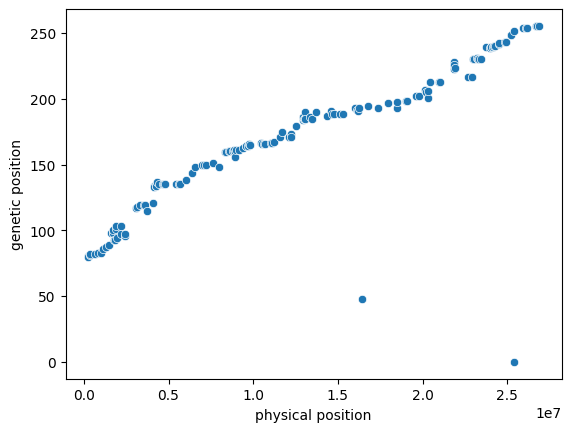

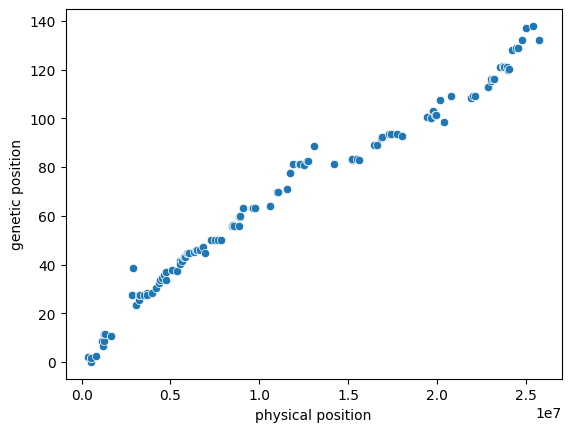

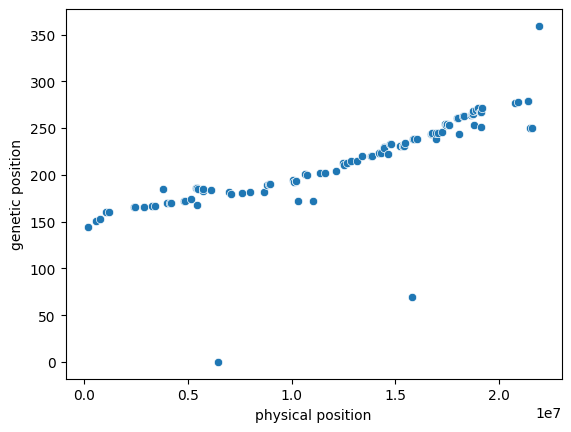

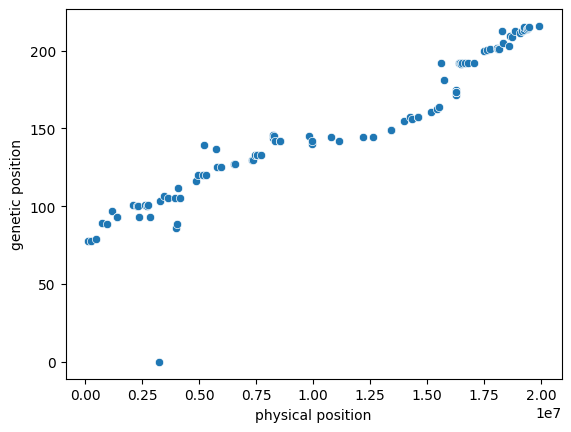

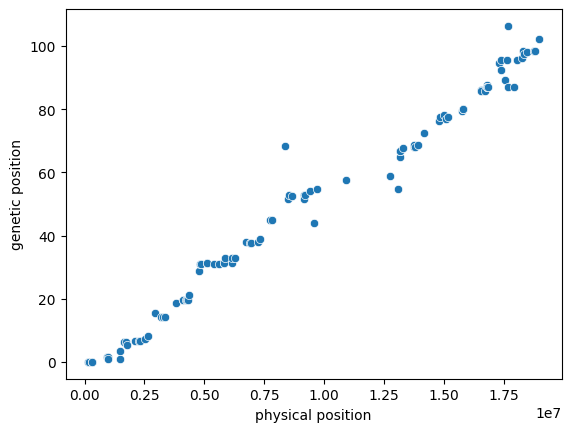

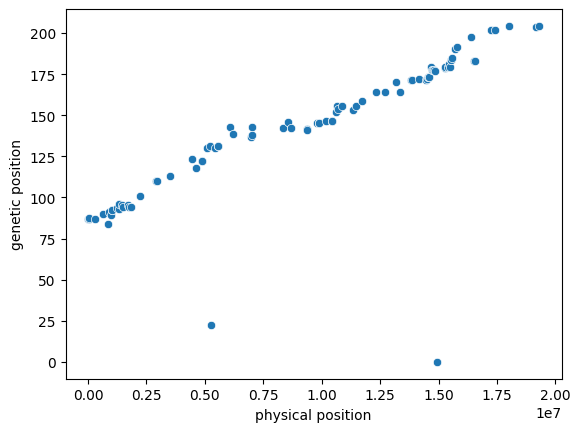

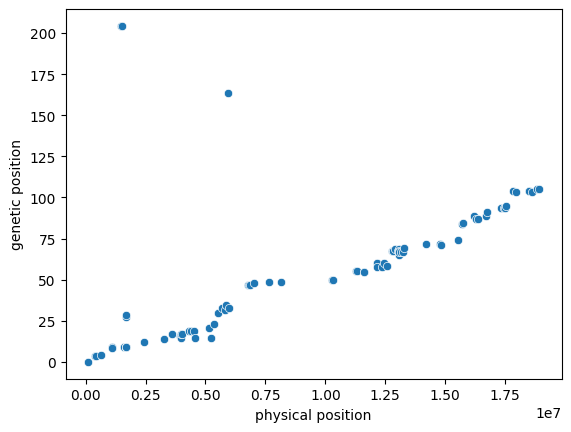

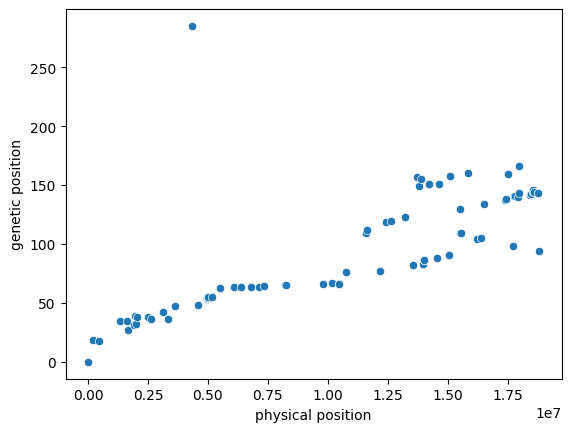

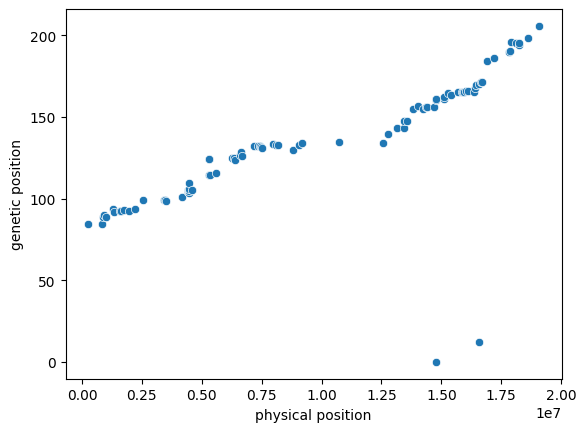

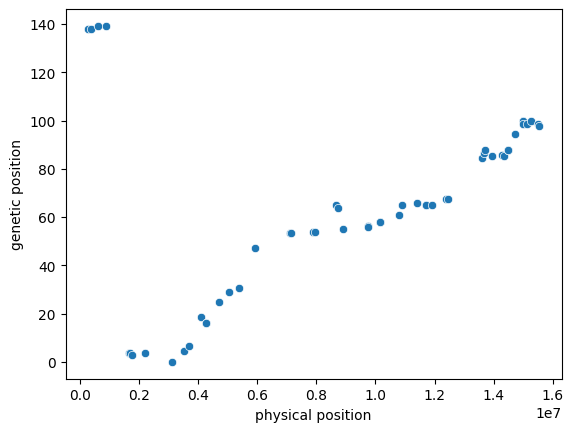

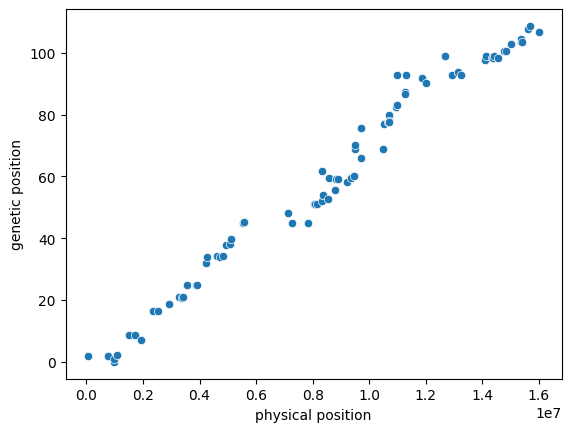

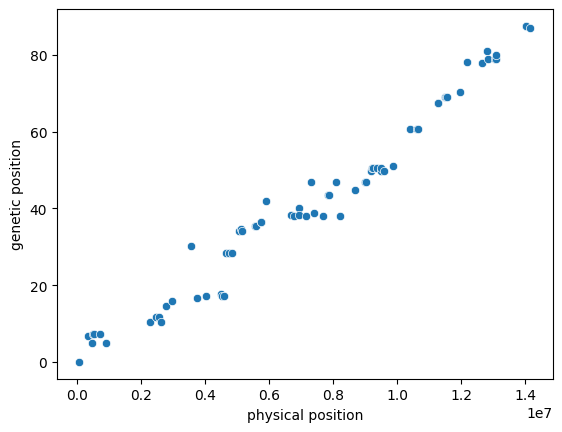

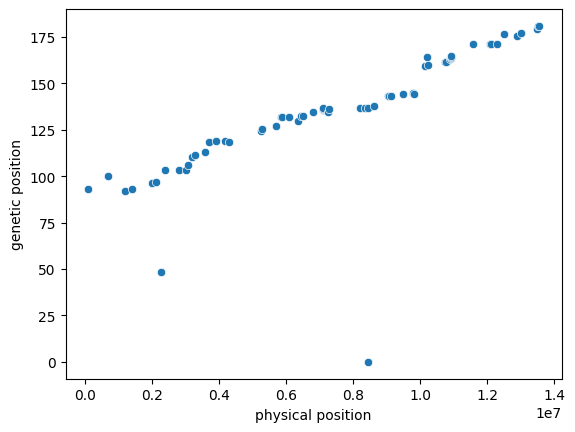

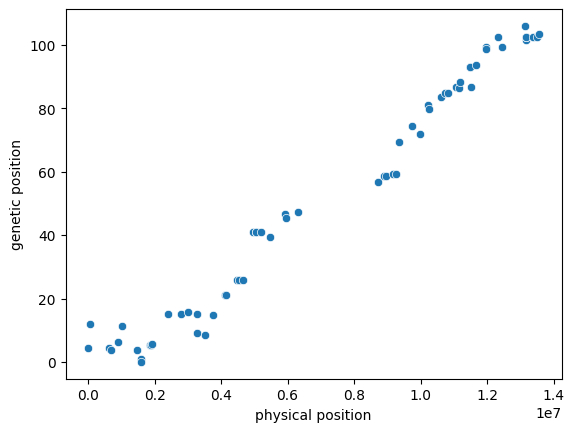

In [74]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
    plt.figure()
    sns.scatterplot(data = marey[marey["chromosome"] == "chr" + str(i)], x = "physical position", y = "genetic position")